In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import folium
import pyeasyga.pyeasyga as pyeasyga
from pyeasyga.pyeasyga import GeneticAlgorithm

In [2]:
#CARGA DE DATOS
#Se reutiliza el código de carga de datos del proyecto anterior

def load_distance_time_dic(path):
    data = pd.read_csv(path)
    distance = {}
    time = {}
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])
        time[origen, destino] = float(data.iloc[i, 3])
    return distance, time
5
def load_vehicles(path):
    data = pd.read_csv(path)
    vehicles = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    return vehicles

def load_demand(path):
    data = pd.read_csv(path)
    demand_dic = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    return demand_dic

def load_capacity(depositPath):
    data= pd.read_csv(depositPath)
    N = len(data)
    capacity_dic = {}
    for i in range(N):
        id = int(data.iloc[i, 1])
    
    return capacity_dic

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot = pd.read_csv(depotsPath)
    client = pd.read_csv(clientsPath)
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]
    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    return coord


In [3]:
distancia,time_dic = load_distance_time_dic('../Datos/caso2.csv')
vehiculos = load_vehicles('../Datos/vehicles.csv')
demanda = load_demand('../Datos/clients.csv')
coord = load_coordinates('../Datos/depots.csv', '../Datos/clients.csv')
print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")
print(f"Time: {time_dic}")



Distancia: {(1, 2): 26758.6, (1, 3): 30281.7, (1, 4): 16633.0, (1, 5): 26682.5, (1, 6): 11143.5, (1, 7): 22303.2, (1, 8): 23954.4, (1, 9): 19324.8, (1, 10): 23519.2, (2, 1): 36838.7, (2, 3): 8088.9, (2, 4): 20656.2, (2, 5): 3040.5, (2, 6): 26605.6, (2, 7): 13207.8, (2, 8): 26859.2, (2, 9): 25021.6, (2, 10): 14769.4, (3, 1): 32641.9, (3, 2): 7954.2, (3, 4): 24137.5, (3, 5): 9617.3, (3, 6): 22408.7, (3, 7): 13554.7, (3, 8): 22662.4, (3, 9): 20824.8, (3, 10): 11688.2, (4, 1): 18374.9, (4, 2): 18491.8, (4, 3): 21973.9, (4, 5): 18415.7, (4, 6): 8141.7, (4, 7): 14036.4, (4, 8): 15646.6, (4, 9): 6450.7, (4, 10): 14630.1, (5, 1): 29333.9, (5, 2): 2467.1, (5, 3): 9430.3, (5, 4): 20566.6, (5, 6): 19100.7, (5, 7): 13118.3, (5, 8): 26335.3, (5, 9): 24497.7, (5, 10): 14245.4, (6, 1): 12890.9, (6, 2): 19093.0, (6, 3): 22616.2, (6, 4): 8349.2, (6, 5): 19017.0, (6, 7): 14637.7, (6, 8): 16288.9, (6, 9): 11659.2, (6, 10): 15853.7, (7, 1): 15966.8, (7, 2): 11021.6, (7, 3): 12047.6, (7, 4): 15685.4, (7, 5

In [4]:
depot_id = 1  # depósito con demanda 0
pf = 15000
ft = 5000
cm = 700
gv = 0.411458

class VRPGeneticAlgorithm:
    def __init__(self, distance, demand, vehicles, coord):
        self.distance = distance
        self.demand = demand
        self.vehicles = vehicles
        self.coord = coord
        self.clientes = [c for c in demand.keys() if c != depot_id]
        self.demand[depot_id] = 0
        
    def create_individual(self, data):
        """Crear un individuo (conjunto de rutas)"""
        n_vehiculos = len(self.vehicles)
        rutas = [[] for _ in range(n_vehiculos)]
        clientes_copy = self.clientes[:]
        random.shuffle(clientes_copy)
        
        # Asignar cada cliente exactamente a un vehículo (round robin)
        for idx, cliente in enumerate(clientes_copy):
            v_id = idx % n_vehiculos
            rutas[v_id].append(cliente)
        
        # Agregar depósito al inicio y fin de cada ruta
        rutas = [[depot_id] + ruta + [depot_id] if ruta else [] for ruta in rutas]
        return rutas

    def mutate_individual(self, individual, data=None):
        """Mutación: mover un cliente de un vehículo a otro"""
        nuevas_rutas = copy.deepcopy(individual)
        
        # Encontrar vehículos con rutas no vacías
        vehiculos_con_rutas = [i for i, ruta in enumerate(nuevas_rutas) if len(ruta) > 2]
        
        if len(vehiculos_con_rutas) < 2:
            return nuevas_rutas
        
        # Elegir dos vehículos distintos
        v1, v2 = random.sample(vehiculos_con_rutas, 2)
        
        if len(nuevas_rutas[v1]) > 2:
            # Seleccionar cliente aleatorio (excluyendo depósitos)
            cliente = random.choice(nuevas_rutas[v1][1:-1])
            nuevas_rutas[v1].remove(cliente)
            
            # Insertar cliente en posición aleatoria en v2
            if len(nuevas_rutas[v2]) == 0:
                nuevas_rutas[v2] = [depot_id, cliente, depot_id]
            else:
                pos = random.randint(1, len(nuevas_rutas[v2]) - 1)
                nuevas_rutas[v2].insert(pos, cliente)
        
        return nuevas_rutas

    def crossover_individuals(self, parent1, parent2, data=None):
        """Cruzamiento: intercambiar segmentos de rutas entre padres"""
        hijo1 = copy.deepcopy(parent1)
        hijo2 = copy.deepcopy(parent2)
        
        # Seleccionar vehículo aleatorio para cruzar
        v = random.randint(0, len(parent1) - 1)
        
        if len(parent1[v]) > 2 and len(parent2[v]) > 2:
            # Extraer rutas sin depósitos
            ruta1 = parent1[v][1:-1]
            ruta2 = parent2[v][1:-1]
            
            if ruta1 and ruta2:
                # Punto de cruce
                split1 = random.randint(0, len(ruta1))
                split2 = random.randint(0, len(ruta2))
                
                # Crear nuevas rutas cruzadas
                nueva_ruta1 = ruta1[:split1] + ruta2[split2:]
                nueva_ruta2 = ruta2[:split2] + ruta1[split1:]
                
                # Reconstruir rutas con depósitos
                hijo1[v] = [depot_id] + nueva_ruta1 + [depot_id] if nueva_ruta1 else []
                hijo2[v] = [depot_id] + nueva_ruta2 + [depot_id] if nueva_ruta2 else []
                
                # Limpiar duplicados y reasignar clientes faltantes
                hijo1 = self._reparar_solucion(hijo1)
                hijo2 = self._reparar_solucion(hijo2)
        
        return hijo1, hijo2

    def _reparar_solucion(self, rutas):
        """Reparar solución eliminando duplicados y asignando clientes faltantes"""
        # Encontrar todos los clientes asignados
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        # Eliminar duplicados
        rutas_limpias = []
        clientes_vistos = set()
        
        for ruta in rutas:
            nueva_ruta = [depot_id]
            for cliente in ruta[1:-1]:  # Excluir depósitos
                if cliente not in clientes_vistos:
                    nueva_ruta.append(cliente)
                    clientes_vistos.add(cliente)
            if len(nueva_ruta) > 1:
                nueva_ruta.append(depot_id)
                rutas_limpias.append(nueva_ruta)
            else:
                rutas_limpias.append([])
        
        # Asignar clientes faltantes
        faltantes = set(self.clientes) - clientes_vistos
        for cliente in faltantes:
            v_id = random.randint(0, len(rutas_limpias) - 1)
            if len(rutas_limpias[v_id]) == 0:
                rutas_limpias[v_id] = [depot_id, cliente, depot_id]
            else:
                rutas_limpias[v_id].insert(-1, cliente)
        
        return rutas_limpias

    def fitness_individual(self, individual, data):
        """Evaluar fitness de un individuo (menor es mejor)"""
        claves_vehiculos = list(self.vehicles.keys())
        total_cost = 0
        
        for v_id, ruta in enumerate(individual):
            if len(ruta) <= 2:  # Ruta vacía
                continue
                
            cap_max, rango_max = self.vehicles[claves_vehiculos[v_id]]
            carga = 0
            distancia_total = 0
            
            # Calcular distancia y carga de la ruta
            for i in range(len(ruta) - 1):
                a, b = ruta[i], ruta[i + 1]
                distancia_total += self.distance.get((a, b), 9999999)
                if b != depot_id:
                    carga += self.demand.get(b, 0)
            
            # Calcular penalizaciones por violación de restricciones
            penalizacion = 0
            if carga > cap_max:
                penalizacion += 1e6 * (carga - cap_max)
            if distancia_total > rango_max:
                penalizacion += 1e6 * (distancia_total - rango_max)
            
            # Costo total del vehículo
            costo_vehiculo = gv * pf * distancia_total + ft + cm + penalizacion
            total_cost += costo_vehiculo
        
        # pyeasyga maximiza fitness, por lo que devolvemos el negativo del costo
        return -total_cost

    def tournament_selection(self, population, tournament_size=3):
        """Selección por torneo"""
        def tournament_select():
            # Seleccionar individuos aleatorios para el torneo
            tournament = random.sample(population, min(tournament_size, len(population)))
            # Devolver el mejor individuo del torneo
            return max(tournament, key=lambda x: x.fitness)
        
        return tournament_select

    def _verificar_asignacion_completa(self, rutas):
        """Verificar que todos los clientes estén asignados"""
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        faltantes = set(self.clientes) - asignados
        return faltantes


def run_ga_pyeasyga(distance, demand, vehicles, coord, 
                            n_generaciones=200, n_poblacion=50, 
                            prob_mutacion=0.2, prob_cruzamiento=0.8,
                            elitismo=5, tournament_size=3):
    """
    Versión mejorada del algoritmo genético con pyeasyga
    """
    # Crear instancia del problema VRP con verificaciones extendidas
    vrp = VRPGeneticAlgorithm(distance, demand, vehicles, coord)
    
    # Configurar algoritmo genético
    ga = GeneticAlgorithm(
        seed_data=None,
        population_size=n_poblacion,
        generations=n_generaciones,
        crossover_probability=prob_cruzamiento,
        mutation_probability=prob_mutacion,
        elitism=True,
        maximise_fitness=True
    )
    
    # Asignar funciones personalizadas
    ga.create_individual = vrp.create_individual
    ga.mutate_function = vrp.mutate_individual
    ga.crossover_function = vrp.crossover_individuals
    ga.fitness_function = vrp.fitness_individual
    
    fitness_history = []

    # Sobrescribir el método rank_population para guardar el mejor fitness
    original_rank_population = ga.rank_population
    def rank_and_record():
        original_rank_population()
        # El mejor fitness está en la primera posición después de ordenar
        fitness_history.append(ga.current_generation[0].fitness)
    ga.rank_population = rank_and_record
    
    # Ejecutar algoritmo genético
    print("Iniciando algoritmo genético mejorado...")
    ga.run()
    
    # Obtener mejor solución
    mejor_solucion = ga.best_individual()[1]
    mejor_fitness = -ga.best_individual()[0]
    
    # Verificaciones finales
    faltantes = vrp._verificar_asignacion_completa(mejor_solucion)
    if faltantes:
        print(f"¡Atención! Algunos nodos no fueron asignados: {faltantes}")
    else:
        print("Todos los nodos fueron asignados correctamente.")
    
    print(f"Mejor costo: {mejor_fitness}")
    
    # Obtener historial de fitness
    fitness_history = [-fitness for fitness in fitness_history]
    
    return mejor_solucion, fitness_history

In [5]:
import folium

def visualizar_rutas_folium(rutas, coord):
    # Crear mapa centrado en depósito o promedio de coordenadas
    lat_dep, lon_dep = coord[depot_id]
    m = folium.Map(location=[lat_dep, lon_dep], zoom_start=11, tiles='Cartodb Positron')

    colors = ['blue', 'green', 'cyan', 'magenta','olive', 'blue', 'orange', 'purple','red']
    icons = ['blue', 'green', 'lightblue', 'pink','lightgreen', 'blue', 'orange', 'darkpurple','red']

    for v, ruta in enumerate(rutas):
        if not ruta or len(ruta) < 2:
            continue

        # Construir lista de coordenadas para PolyLine: [(lat, lon), (lat, lon), ...]
        coords_ruta = [coord[n] for n in ruta]

        # Dibujar la ruta
        folium.PolyLine(
            coords_ruta,
            color=colors[v % len(colors)],
            weight=5,
            opacity=0.7,
            tooltip=f'Vehículo {v}'
        ).add_to(m)

        # Marcador inicio (depósito)
        folium.Marker(
            coords_ruta[0],
            popup="Inicio (Depósito)",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)

        # Marcador fin de ruta
        folium.Marker(
            coords_ruta[-1],
            popup=f"Llegada Vehículo {v}",
            icon=folium.Icon(color=icons[v % len(icons)], icon='flag')
        ).add_to(m)

    return m


Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 126425916536.57582


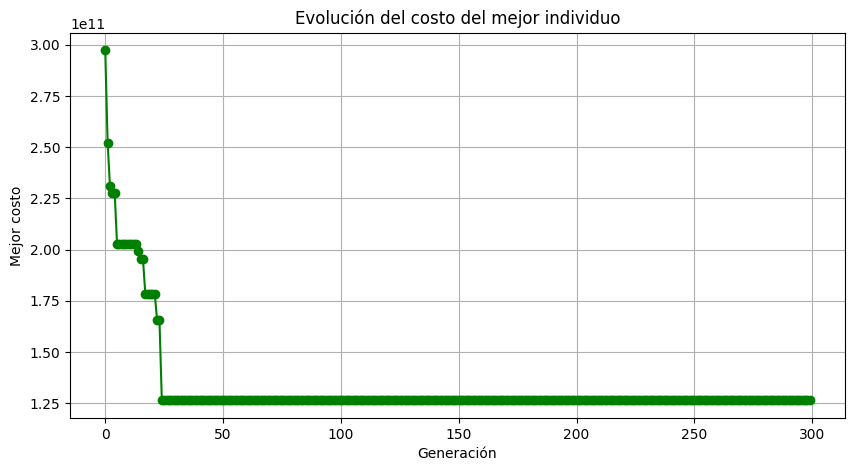

In [6]:
solucion, evol = run_ga_pyeasyga(distancia, demanda, vehiculos, coord, n_generaciones=300, n_poblacion=50, elitismo=5, prob_mutacion=0.2)
def graficar_evolucion_costos(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor costo')
    plt.title('Evolución del costo del mejor individuo')
    plt.grid(True)
    plt.show()

graficar_evolucion_costos(evol)
mapa = visualizar_rutas_folium(solucion, coord)
mapa

## Analisis de Escalabilidad

## Comparación son soluciones previas (Pyomo)